___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [26]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
# You can install torchmeterics using: pip install torchmetrics

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [27]:
#from fontsetting import font_cmu
#plt = font_cmu(plt)
# Disable LaTeX
#plt.rcParams['text.usetex'] = False

___
### Check the hardware that is at your disposal

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)


Device available: cuda


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [29]:
# Loading TIFF images for Super-resolution
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
    
    # Get the number of samples in the dataset
    def __len__(self):
        return len(self.filenames)

    # Get the sample at the given index
    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res to 128x128 (ensuring correct input size)
        low_res = low_res.resize((128, 128), Image.BICUBIC)

        # Apply transformations
        if self.transform:
            high_res = self.transform(high_res)
            low_res = self.transform(low_res)

        return low_res, high_res  # Returning input-output pairs

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform)

# Function to create data loader
def create_loader(dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)


Number of images in the dataset: 240


___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [30]:
# class TrivialNet(nn.Module):
#     def __init__(self):
#         super(TrivialNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, padding=1)

#     def forward(self, x):
#         x = self.conv1(x)  # First conv layer
#         x = self.conv2(x)  # Output layer
#         return x

# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()
        
#          # Encoder
#         self.encoder = nn.Sequential(
#              nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
#              #nn.BatchNorm2d(64),
#              nn.ReLU(inplace=True),
#              #nn.GELU(),
#              #nn.LayerNorm(64, eps=1e-6), # add in Layer normalization
#              nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#              #nn.BatchNorm2d(64),
#              nn.ReLU(inplace=True),
#              #nn.GELU(),
#              #nn.LayerNorm(64, eps=1e-6), # add in Layer normalization
#              nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by half
#          )

#          # Bottleneck
#         self.bottleneck = nn.Sequential(
#              nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#              #nn.BatchNorm2d(128),
#              nn.ReLU(inplace=True),
#              #nn.GELU(),
#              #nn.LayerNorm([128, 128, 128], eps=1e-6),  # add in Layer normalization
#              nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#              #nn.BatchNorm2d(128),
#              nn.ReLU(inplace=True),
#              #nn.GELU()
#              #nn.LayerNorm(128, eps=1e-6), # add in layer normalization
#          )

#          # Decoder
#         self.decoder = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
#             #nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#              #nn.GELU(),
#              #nn.LayerNorm(64,eps=1e-6), # add in layer normalizatoin
#              nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
#              nn.Sigmoid()  # For output between 0 and 1 (or you could use ReLU, depending on your task)
#          )

#         # Upsample Layer
#         self.upsample = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsample to match decoder size

#     def forward(self, x):
#          # Encoder path
#          x1 = self.encoder(x)

#          # Bottleneck (the bottom of the U)
#          x2 = self.bottleneck(x1)

#          # Decoder path with upsampling
#          x3 = self.upsample(x2)

#          # Ensure the size matches before concatenation
#          # If x3 is smaller than x1, crop x1 to match x3's dimensions
#          if x3.size(2) != x1.size(2) or x3.size(3) != x1.size(3):
#              x1 = nn.functional.interpolate(x1, size=(x3.size(2), x3.size(3)), mode='bilinear', align_corners=False)

#         # Concatenate encoder features with decoder output (skip connection)
#          x4 = torch.cat([x3, x1], dim=1)

#          # Final output from decoder
#          out = self.decoder(x4)
#          return out

#######################################################

# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(channels),
#             nn.GELU(),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(channels),
#             # nn.LayerNorm([channels, H, W])  # Optional: Uncomment if needed
#         )

#     def forward(self, x):
#         return x + self.block(x)

# class UNetEnhanced(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNetEnhanced, self).__init__()

#         # Encoder
#         self.down_conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
#             nn.GELU(),
#             ResidualBlock(64),
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # learned downsampling
#         )

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.GELU(),
#             ResidualBlock(128)
#         )

#         # Upsample
#         self.upsample = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.GELU(),
#             nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
#             #nn.Tanh()  # Output in [-1, 1]; change to Sigmoid() if needed
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x1 = self.down_conv1(x)
#         x2 = self.bottleneck(x1)
#         x3 = self.upsample(x2)

#         # Resize x1 if needed
#         if x3.shape[2:] != x1.shape[2:]:
#             x1 = F.interpolate(x1, size=x3.shape[2:], mode='bilinear', align_corners=False)

#         x_cat = torch.cat([x3, x1], dim=1)
#         out = self.decoder(x_cat)
#         return out
    
#############################################

# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.GELU(),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             # nn.LayerNorm([channels, H, W])  # Optional: Uncomment if needed
#         )

#     def forward(self, x):
#         return x + self.block(x)

# class UNetEnhanced(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNetEnhanced, self).__init__()

#         # Encoder
#         self.down_conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
#             nn.GELU(),
#             ResidualBlock(64),
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # learned downsampling
#         )

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.GELU(),
#             ResidualBlock(128)
#         )

#         # Upsample
#         self.upsample = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.GELU(),
#             nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
#             nn.Tanh()  # Output in [-1, 1]; change to Sigmoid() if needed
#         )

#     def forward(self, x):
#         x1 = self.down_conv1(x)
#         x2 = self.bottleneck(x1)
#         x3 = self.upsample(x2)

#         # Resize x1 if needed
#         if x3.shape[2:] != x1.shape[2:]:
#             x1 = F.interpolate(x1, size=x3.shape[2:], mode='bilinear', align_corners=False)

#         x_cat = torch.cat([x3, x1], dim=1)
#         out = self.decoder(x_cat)
#         return out # has a weird gradient problem... lets try the one below

#############################################

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels), # try adding  batch norm to help
            nn.GELU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels), # trying add batch norm to help
            # nn.LayerNorm([channels, H, W])  # Optional: Uncomment if needed
        )

    def forward(self, x):
        return x + self.block(x)

class UNetEnhancedv2(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetEnhancedv2, self).__init__()

        # Encoder
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.GELU(),
            ResidualBlock(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # learned downsampling
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GELU(),
            ResidualBlock(128)
        )

        # Upsample
        self.upsample = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Dropout(0.1),  # try using dropout to avoid overfitting
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
           # nn.Tanh()  # Output in [-1, 1]; change to Sigmoid() if needed - try commenting out to help w/gradient issue
        )

    def forward(self, x):
        x1 = self.down_conv1(x)
        x2 = self.bottleneck(x1)
        x3 = self.upsample(x2)

        # Resize x1 if needed
        if x3.shape[2:] != x1.shape[2:]:
            x1 = F.interpolate(x1, size=x3.shape[2:], mode='bilinear', align_corners=False)

        x_cat = torch.cat([x3, x1], dim=1)
        out = self.decoder(x_cat)
        return out
    

####################################################################################### 


# class UNetSuperRes(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNetSuperRes, self).__init__()

#         def conv_block(in_c, out_c):
#             return nn.Sequential(
#                 nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
#                 nn.InstanceNorm2d(out_c),
#                 nn.GELU(),
#                 nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
#                 nn.InstanceNorm2d(out_c),
#                 nn.GELU()
#             )

#         self.enc1 = conv_block(in_channels, 64)
#         self.pool1 = nn.MaxPool2d(2)

#         self.enc2 = conv_block(64, 128)
#         self.pool2 = nn.MaxPool2d(2)

#         self.enc3 = conv_block(128, 256)
#         self.pool3 = nn.MaxPool2d(2)

#         self.bottleneck = conv_block(256, 512)

#         self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
#         self.dec3 = conv_block(512 + 256, 256)

#         self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
#         self.dec2 = conv_block(256 + 128, 128)

#         self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
#         self.dec1 = conv_block(128 + 64, 64)

#         self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
#         # Note: No activation here — assume input/output are normalized between 0-1

#     def forward(self, x):
#         # Encoder
#         x1 = self.enc1(x)
#         x2 = self.enc2(self.pool1(x1))
#         x3 = self.enc3(self.pool2(x2))

#         # Bottleneck
#         x4 = self.bottleneck(self.pool3(x3))

#         # Decoder
#         x = self.up3(x4)
#         x = torch.cat([x, x3], dim=1)
#         x = self.dec3(x)

#         x = self.up2(x)
#         x = torch.cat([x, x2], dim=1)
#         x = self.dec2(x)

#         x = self.up1(x)
#         x = torch.cat([x, x1], dim=1)
#         x = self.dec1(x)

#         out = self.final_conv(x)
#         return out



___
### Create a function to execute training. Note, we will call this function later.

In [31]:
def train_model(model, opt, criterion, train_loader, num_epoch):
    avg_train_losses = []

    for epoch in range(num_epoch):  # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0

        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):  # Loop over mini-batches
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            # Upsample low-resolution input to 256x256
            x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)

            opt.zero_grad()  # Delete previous gradients
            y_hat_tr_batch = model(x_tr_batch)  # Forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch)  # Compute loss
            loss.backward()  # Backward pass
            opt.step()  # Update weights
            total_train_loss += loss.item()  # Accumulate loss

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average loss
        avg_train_losses.append(avg_train_loss)  # Store average loss

    # Plot training loss
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch + 1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, Loss: 0.011130
Epoch 1, Iteration 20, Loss: 0.005606
Epoch 1, Iteration 30, Loss: 0.002863
Epoch 1, Iteration 40, Loss: 0.003192
Epoch 2, Iteration 10, Loss: 0.002056
Epoch 2, Iteration 20, Loss: 0.002266
Epoch 2, Iteration 30, Loss: 0.002367
Epoch 2, Iteration 40, Loss: 0.001540
Epoch 3, Iteration 10, Loss: 0.001540
Epoch 3, Iteration 20, Loss: 0.001399
Epoch 3, Iteration 30, Loss: 0.001615
Epoch 3, Iteration 40, Loss: 0.001161
Epoch 4, Iteration 10, Loss: 0.001783
Epoch 4, Iteration 20, Loss: 0.002089
Epoch 4, Iteration 30, Loss: 0.001166
Epoch 4, Iteration 40, Loss: 0.001311
Epoch 5, Iteration 10, Loss: 0.000979
Epoch 5, Iteration 20, Loss: 0.001536
Epoch 5, Iteration 30, Loss: 0.000947
Epoch 5, Iteration 40, Loss: 0.000982
Epoch 6, Iteration 10, Loss: 0.000926
Epoch 6, Iteration 20, Loss: 0.001476
Epoch 6, Iteration 30, Loss: 0.001464
Epoch 6, Iteration 40, Loss: 0.001244
Epoch 7, Iteration 10, Loss: 0.001098
Epoch 7, Iteration 20, Loss: 0.000986
Epoch 7, Ite

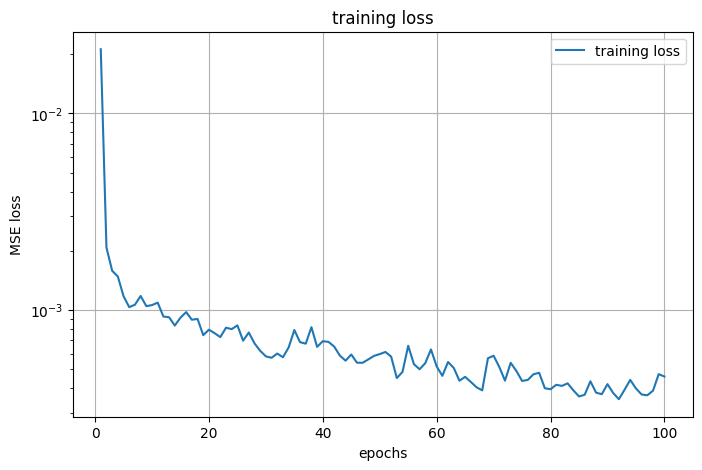

In [32]:
batch_size = 5  # Number of complete images in each batch
lr = 1e-3  # Learning rate
num_epoch = 100  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = UNetEnhancedv2(in_channels=1, out_channels=1).to(device) # see if this helps gradient problem from below UNetEnhanced
#model = UNetEnhanced(in_channels=1, out_channels=1).to(device) # test U-Net instead of TrivialNet
#model = UNetSuperRes(in_channels=1, out_channels=1).to(device) # test U-Net instead of TrivialNet
#model = UNet(in_channels=1, out_channels=1).to(device) # test U-Net instead of TrivialNet
#model = TrivialNet().to(device)  # Pick a model and move to GPU/CPU
opt = optim.Adam(model.parameters(), lr=lr)  # Pick an optimizer
criterion = nn.MSELoss()  # Pick a loss function

# Train the model
train_model(model, opt, criterion, train_loader, num_epoch)

___
### Apply it one of the validation image

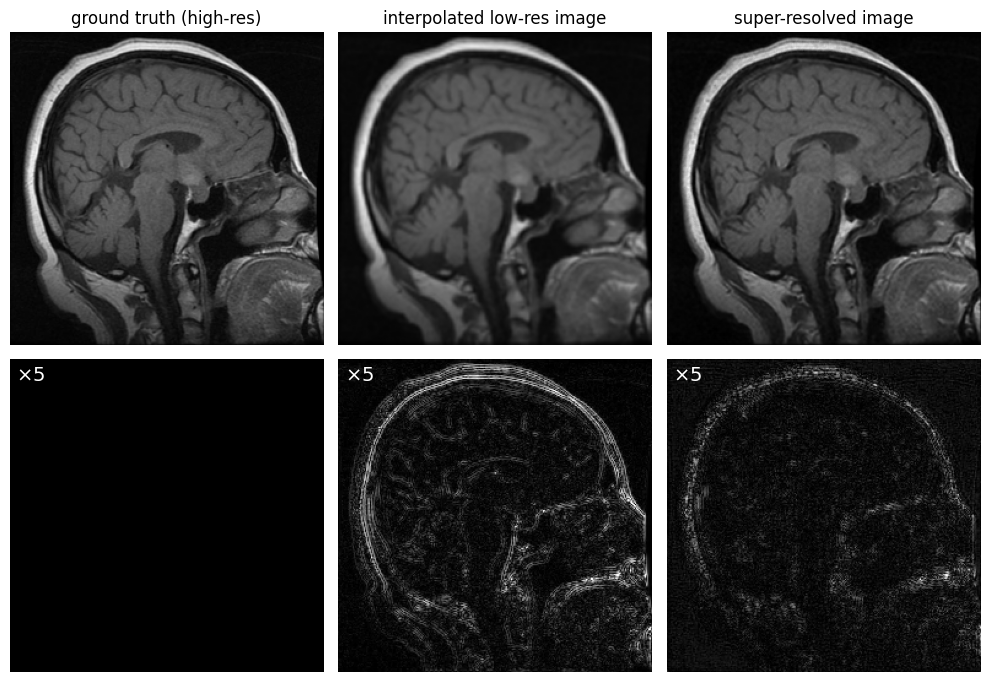

In [33]:
# Create the dataset for validation images
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform)

# Load one (low-res, high-res) image pair from validation dataset and move it to the dedvice
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Upsample low-resolution image to 256x256 for both model input and error visualization
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)

# Apply the trained model to super-resolve the interpolated low-res image
val_super_res = model(val_low_res_interpolated.unsqueeze(0)).detach().squeeze(0)  # Remove batch dimension

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the interpolated version for error maps
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('super-resolved image')
ax[0, 2].axis('off')

# Error maps
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()


### Compute PSNR and SSIM over the entire validation dataset

In [34]:
# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Accumulators
total_psnr_interpolated = 0
total_psnr_super_resolved = 0
total_ssim_interpolated = 0
total_ssim_super_resolved = 0
num_samples = len(val_dataset)

# Loop over validation set
for i in range(num_samples):
    val_low_res, val_high_res = val_dataset[i]
    val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

    # Compute data range dynamically
    data_range = val_high_res.max() - val_high_res.min()
    ssim_metric.data_range = data_range

    # Upsample low-res image
    val_low_res_up = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False)
    val_high_res = val_high_res.unsqueeze(0)  # Add batch dim
    val_super_res = model(val_low_res_up).detach()

    # PSNR
    psnr_interp = psnr_metric(val_low_res_up, val_high_res).item()
    psnr_sr = psnr_metric(val_super_res, val_high_res).item()

    # SSIM (data_range is now set in metric initialization)
    ssim_interp = ssim_metric(val_low_res_up, val_high_res).item()
    ssim_sr = ssim_metric(val_super_res, val_high_res).item()

    # Accumulate
    total_psnr_interpolated += psnr_interp
    total_psnr_super_resolved += psnr_sr
    total_ssim_interpolated += ssim_interp
    total_ssim_super_resolved += ssim_sr

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples
avg_psnr_sr = total_psnr_super_resolved / num_samples
avg_ssim_interp = total_ssim_interpolated / num_samples
avg_ssim_sr = total_ssim_super_resolved / num_samples

# Print results
print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')

Average PSNR (interpolated): 30.81 dB
Average PSNR (super-resolved): 33.08 dB
Average SSIM (interpolated): 0.9056
Average SSIM (super-resolved): 0.9276
